# ResNet Training on CIFAR-100

This notebook implements ResNet training from scratch on CIFAR-100 dataset.

**Target**: 73% top-1 accuracy
**Model**: ResNet-56 (optimized for CIFAR-100)
**Epochs**: ~100-150 epochs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla V100-PCIE-16GB


## 1. Data Loading and Augmentation

We'll use strong data augmentation strategies that are proven to work well for CIFAR-100:
- Random Crop with padding
- Random Horizontal Flip
- AutoAugment (optional but helps)
- Normalization

In [2]:
# Data augmentation and normalization
# CIFAR-100 mean and std
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

class Cutout:
    """Randomly mask out one or more patches from an image."""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

# Training transforms with strong augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    Cutout(n_holes=1, length=16),
])

# Test transforms (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Download and load datasets
train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=test_transform
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=2, pin_memory=True)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Number of classes: 100')

100%|██████████| 169M/169M [00:19<00:00, 8.73MB/s] 


Training samples: 50000
Test samples: 10000
Number of classes: 100


## 2. ResNet Model Definition

We'll implement ResNet-56 which is specifically designed for CIFAR datasets. The architecture uses:
- 3 stages with 9 residual blocks each (3n layers where n=9)
- Filter sizes: [16, 32, 64]
- No max pooling (stride 2 for downsampling)
- Kaiming initialization

In [3]:
class BasicBlock(nn.Module):
    """Basic residual block for ResNet (CIFAR version)"""
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out


class ResNet(nn.Module):
    """ResNet for CIFAR-100"""
    
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 16
        
        # Initial convolution (CIFAR uses 3x3 conv, not 7x7)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        
        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)
        
        # Initialize weights with Kaiming initialization
        self._initialize_weights()
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out


def ResNet56(num_classes=100):
    """ResNet-56 for CIFAR-100 (6n+2 architecture with n=9)"""
    return ResNet(BasicBlock, [9, 9, 9], num_classes=num_classes)


def ResNet110(num_classes=100):
    """ResNet-110 for CIFAR-100 (6n+2 architecture with n=18)"""
    return ResNet(BasicBlock, [18, 18, 18], num_classes=num_classes)


# Create model
model = ResNet56(num_classes=100).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'\nModel architecture:')
print(model)

Total parameters: 861,620
Trainable parameters: 861,620

Model architecture:
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

## 3. Training Configuration

Key hyperparameters for achieving 73%+ accuracy:
- **Optimizer**: SGD with momentum (0.9) and weight decay
- **Learning Rate**: 0.1 with cosine annealing
- **Batch Size**: 128
- **Epochs**: 150 (can stop early if target reached)
- **Weight Decay**: 5e-4 (important for regularization)

In [4]:
# Training configuration
num_epochs = 150
initial_lr = 0.1
weight_decay = 5e-4
momentum = 0.9

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=initial_lr, 
                     momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler: Cosine Annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

# Alternative: Step decay (uncomment to use)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

print(f'Training configuration:')
print(f'  Epochs: {num_epochs}')
print(f'  Initial LR: {initial_lr}')
print(f'  Weight Decay: {weight_decay}')
print(f'  Momentum: {momentum}')
print(f'  Batch Size: {batch_size}')
print(f'  Scheduler: Cosine Annealing')

Training configuration:
  Epochs: 150
  Initial LR: 0.1
  Weight Decay: 0.0005
  Momentum: 0.9
  Batch Size: 128
  Scheduler: Cosine Annealing


## 4. Training and Evaluation Functions

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.3f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, test_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Validation'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def save_checkpoint(model, optimizer, epoch, acc, filename='checkpoint.pth'):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': acc,
    }
    torch.save(checkpoint, filename)
    print(f'Checkpoint saved: {filename}')

## 5. Training Loop

This will train for up to 150 epochs, saving the best model based on validation accuracy.

In [6]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_acc = 0.0
target_acc = 73.0

print('Starting training...')
print('='*80)

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Print epoch summary
    print(f'\nEpoch {epoch+1} Summary:')
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        save_checkpoint(model, optimizer, epoch+1, val_acc, 'best_model.pth')
        print(f'  ✓ New best accuracy: {best_acc:.2f}%')
    
    # Check if target reached
    if val_acc >= target_acc:
        print(f'\n🎉 Target accuracy of {target_acc}% reached!')
        print(f'Best validation accuracy: {best_acc:.2f}%')
        break
    
    print('-'*80)

print('\n' + '='*80)
print('Training completed!')
print(f'Best validation accuracy: {best_acc:.2f}%')

Validation: 100%|██████████| 79/79 [00:01<00:00, 47.79it/s]


Epoch 1 Summary:
  Train Loss: 4.4447 | Train Acc: 2.70%
  Val Loss:   4.4773 | Val Acc:   3.56%

Epoch 2 Summary:
  Train Loss: 4.0379 | Train Acc: 6.51%
  Val Loss:   3.8102 | Val Acc:   9.91%

Epoch 3 Summary:
  Train Loss: 3.7255 | Train Acc: 11.69%
  Val Loss:   3.5965 | Val Acc:   13.96%

Epoch 4 Summary:
  Train Loss: 3.4596 | Train Acc: 16.15%
  Val Loss:   3.2573 | Val Acc:   20.12%

Epoch 5 Summary:
  Train Loss: 3.2052 | Train Acc: 20.81%
  Val Loss:   3.3455 | Val Acc:   20.57%

Epoch 6 Summary:
  Train Loss: 2.9534 | Train Acc: 25.25%
  Val Loss:   2.9886 | Val Acc:   27.45%

Epoch 9 Summary:
  Train Loss: 2.5014 | Train Acc: 34.60%
  Val Loss:   2.4616 | Val Acc:   36.56%

Epoch 11 Summary:
  Train Loss: 2.3295 | Train Acc: 38.34%
  Val Loss:   2.4002 | Val Acc:   37.87%

Epoch 13 Summary:
  Train Loss: 2.2167 | Train Acc: 40.90%
  Val Loss:   2.4915 | Val Acc:   38.42%

Epoch 14 Summary:
  Train Loss: 2.1733 | Train Acc: 42.12%
  Val Loss:   2.3283 | Val Acc:   40.46%



## 6. Visualize Training Progress

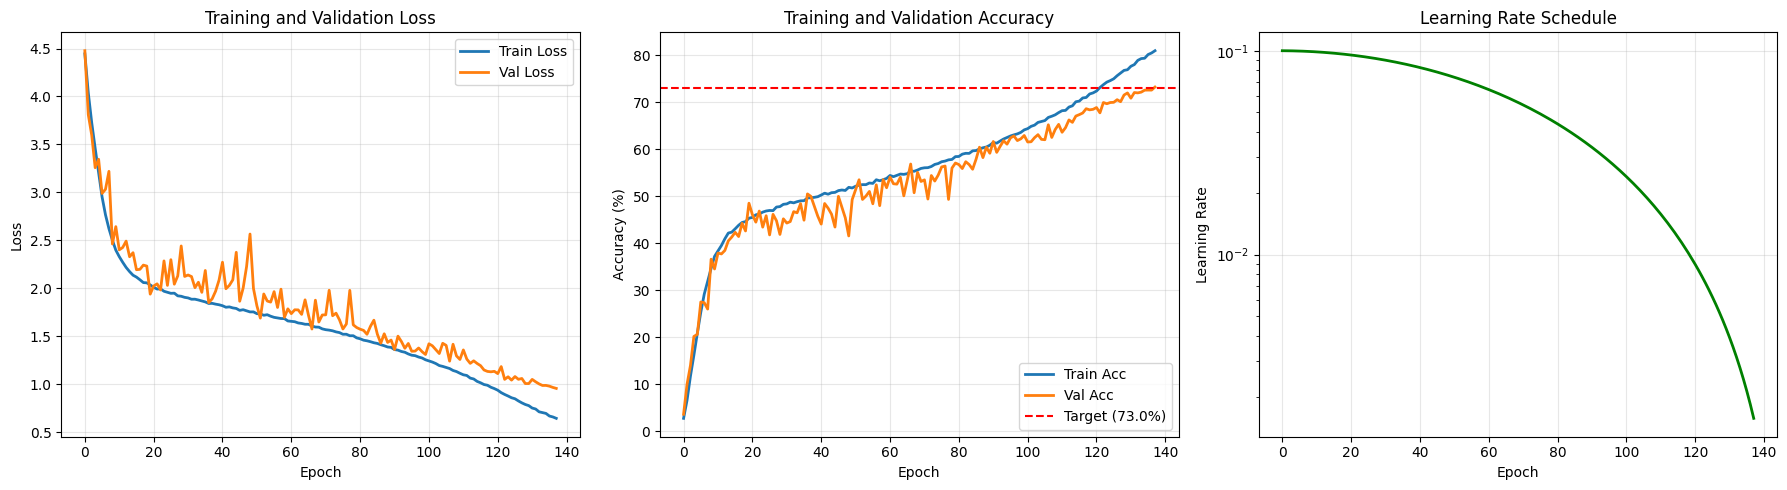


Final Results:
  Best Validation Accuracy: 73.19%
  Final Train Accuracy: 80.92%
  Final Val Accuracy: 73.19%


In [7]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].axhline(y=target_acc, color='r', linestyle='--', label=f'Target ({target_acc}%)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot learning rate
axes[2].plot(history['lr'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nFinal Results:')
print(f'  Best Validation Accuracy: {best_acc:.2f}%')
print(f'  Final Train Accuracy: {history["train_acc"][-1]:.2f}%')
print(f'  Final Val Accuracy: {history["val_acc"][-1]:.2f}%')

## 7. Load Best Model and Final Evaluation

In [8]:
# Load best model
if os.path.exists('best_model.pth'):
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'Loaded best model from epoch {checkpoint["epoch"]} with accuracy {checkpoint["accuracy"]:.2f}%')
    
    # Final evaluation
    final_loss, final_acc = validate(model, test_loader, criterion, device)
    print(f'\nFinal Test Accuracy: {final_acc:.2f}%')
    print(f'Final Test Loss: {final_loss:.4f}')
else:
    print('No checkpoint found. Using current model weights.')
    final_acc = best_acc

Validation:  85%|████████▍ | 67/79 [00:01<00:00, 51.07it/s]


#

## 8. Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) helps visualize which parts of the image the model focuses on when making predictions. This is useful for understanding model behavior and debugging.

In [11]:
class GradCAM:
    """Grad-CAM implementation for visualization"""
    
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM
        
        Args:
            model: The neural network model
            target_layer: The layer to visualize (e.g., model.layer3[-1])
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        """Hook to save forward pass activations"""
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        """Hook to save backward pass gradients"""
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        """
        Generate Grad-CAM heatmap
        
        Args:
            input_image: Input image tensor (1, C, H, W)
            target_class: Target class index (if None, uses predicted class)
            
        Returns:
            cam: Grad-CAM heatmap (H, W)
            predicted_class: Predicted class index
        """
        self.model.eval()
        
        # Forward pass
        output = self.model(input_image)
        
        # Get predicted class if not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        class_score = output[0, target_class]
        class_score.backward()
        
        # Generate CAM
        # Get the gradients and activations
        gradients = self.gradients[0]  # (C, H, W)
        activations = self.activations[0]  # (C, H, W)
        
        # Global average pooling of gradients
        weights = gradients.mean(dim=(1, 2))  # (C,)
        
        # Weighted combination of activation maps
        # Create cam on the same device as activations (FIX: device mismatch)
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)  # (H, W)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU (we only want positive influence)
        cam = torch.relu(cam)
        
        # Normalize to [0, 1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.cpu().numpy(), target_class
    
    def visualize(self, input_image, original_image, target_class=None, class_names=None):
        """
        Visualize Grad-CAM overlay on image
        
        Args:
            input_image: Preprocessed input tensor (1, C, H, W)
            original_image: Original image as numpy array (H, W, C) in [0, 1]
            target_class: Target class index (if None, uses predicted class)
            class_names: List of class names for display
            
        Returns:
            fig: Matplotlib figure
        """
        import cv2
        from matplotlib import cm
        
        # Generate CAM
        cam, pred_class = self.generate_cam(input_image, target_class)
        
        # Resize CAM to match original image size
        cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
        
        # Apply colormap
        heatmap = cm.jet(cam_resized)[:, :, :3]  # Remove alpha channel
        
        # Superimpose heatmap on original image
        superimposed = heatmap * 0.4 + original_image * 0.6
        superimposed = np.clip(superimposed, 0, 1)
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Heatmap
        axes[1].imshow(cam_resized, cmap='jet')
        axes[1].set_title('Grad-CAM Heatmap')
        axes[1].axis('off')
        
        # Superimposed
        axes[2].imshow(superimposed)
        if class_names:
            axes[2].set_title(f'Overlay\nPredicted: {class_names[pred_class]}')
        else:
            axes[2].set_title(f'Overlay\nPredicted Class: {pred_class}')
        axes[2].axis('off')
        
        plt.tight_layout()
        return fig


def denormalize_image(tensor, mean, std):
    """Denormalize image tensor for visualization"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)


def get_random_image_from_dataset(dataset, idx=None):
    """
    Get a random image from the dataset
    
    Args:
        dataset: CIFAR-100 dataset
        idx: Specific index (if None, selects random)
        
    Returns:
        image_tensor: Preprocessed image tensor
        original_image: Original image as numpy array
        label: Ground truth label
    """
    if idx is None:
        idx = np.random.randint(0, len(dataset))
    
    image_tensor, label = dataset[idx]
    
    # Denormalize for visualization
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    original_image = denormalize_image(image_tensor, mean, std)
    original_image = original_image.permute(1, 2, 0).numpy()
    
    return image_tensor.unsqueeze(0), original_image, label, idx


# CIFAR-100 class names
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

print('Grad-CAM utilities loaded successfully!')
print('Available layers for visualization:')
print('  - model.layer1 (16 channels, 32x32)')
print('  - model.layer2 (32 channels, 16x16)')
print('  - model.layer3 (64 channels, 8x8)')
print('You can also access specific blocks: model.layer3[0], model.layer3[-1], etc.')

Grad-CAM utilities loaded successfully!
Available layers for visualization:
  - model.layer1 (16 channels, 32x32)
  - model.layer2 (32 channels, 16x16)
  - model.layer3 (64 channels, 8x8)
You can also access specific blocks: model.layer3[0], model.layer3[-1], etc.


### Example 1: Visualize Grad-CAM for a Random Image

Let's visualize what the model focuses on for a random test image.

Image index: 860
True label: ray


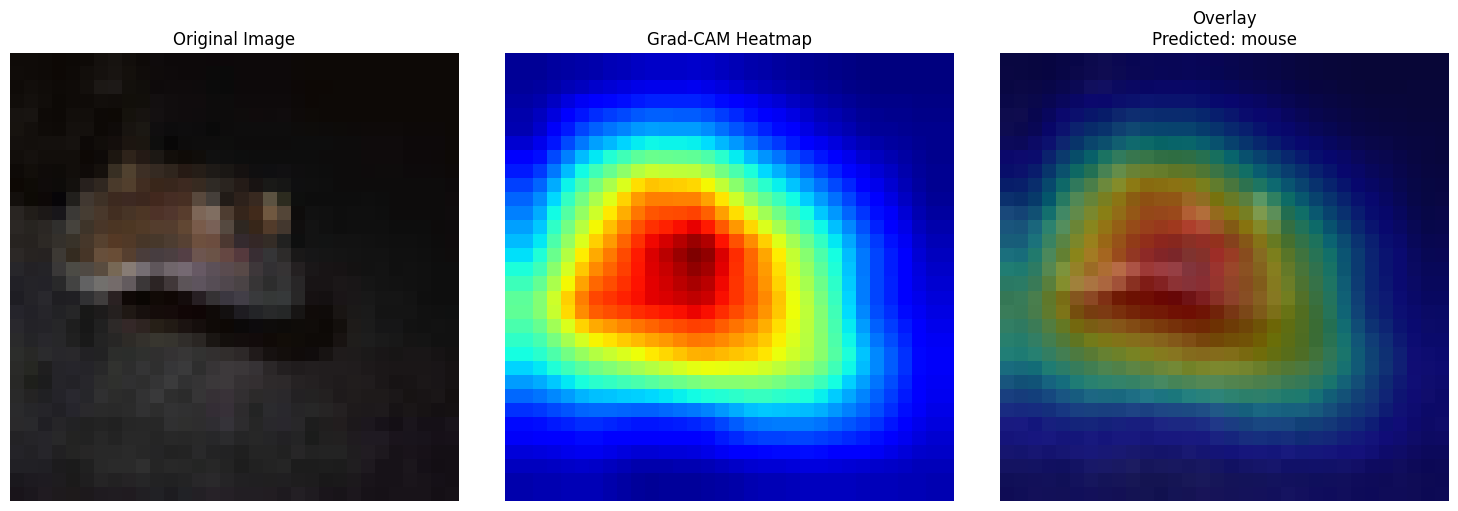

In [12]:
# Get a random test image
image_tensor, original_image, true_label, idx = get_random_image_from_dataset(test_dataset)

# Move image to device
image_tensor = image_tensor.to(device)

# Initialize Grad-CAM with the last layer of layer3
# This is typically the most informative layer for visualization
gradcam = GradCAM(model, target_layer=model.layer3[-1])

# Visualize
print(f'Image index: {idx}')
print(f'True label: {cifar100_classes[true_label]}')

fig = gradcam.visualize(image_tensor, original_image, class_names=cifar100_classes)
plt.show()

### Example 2: Compare Different Layers

Let's see how different layers focus on different features.

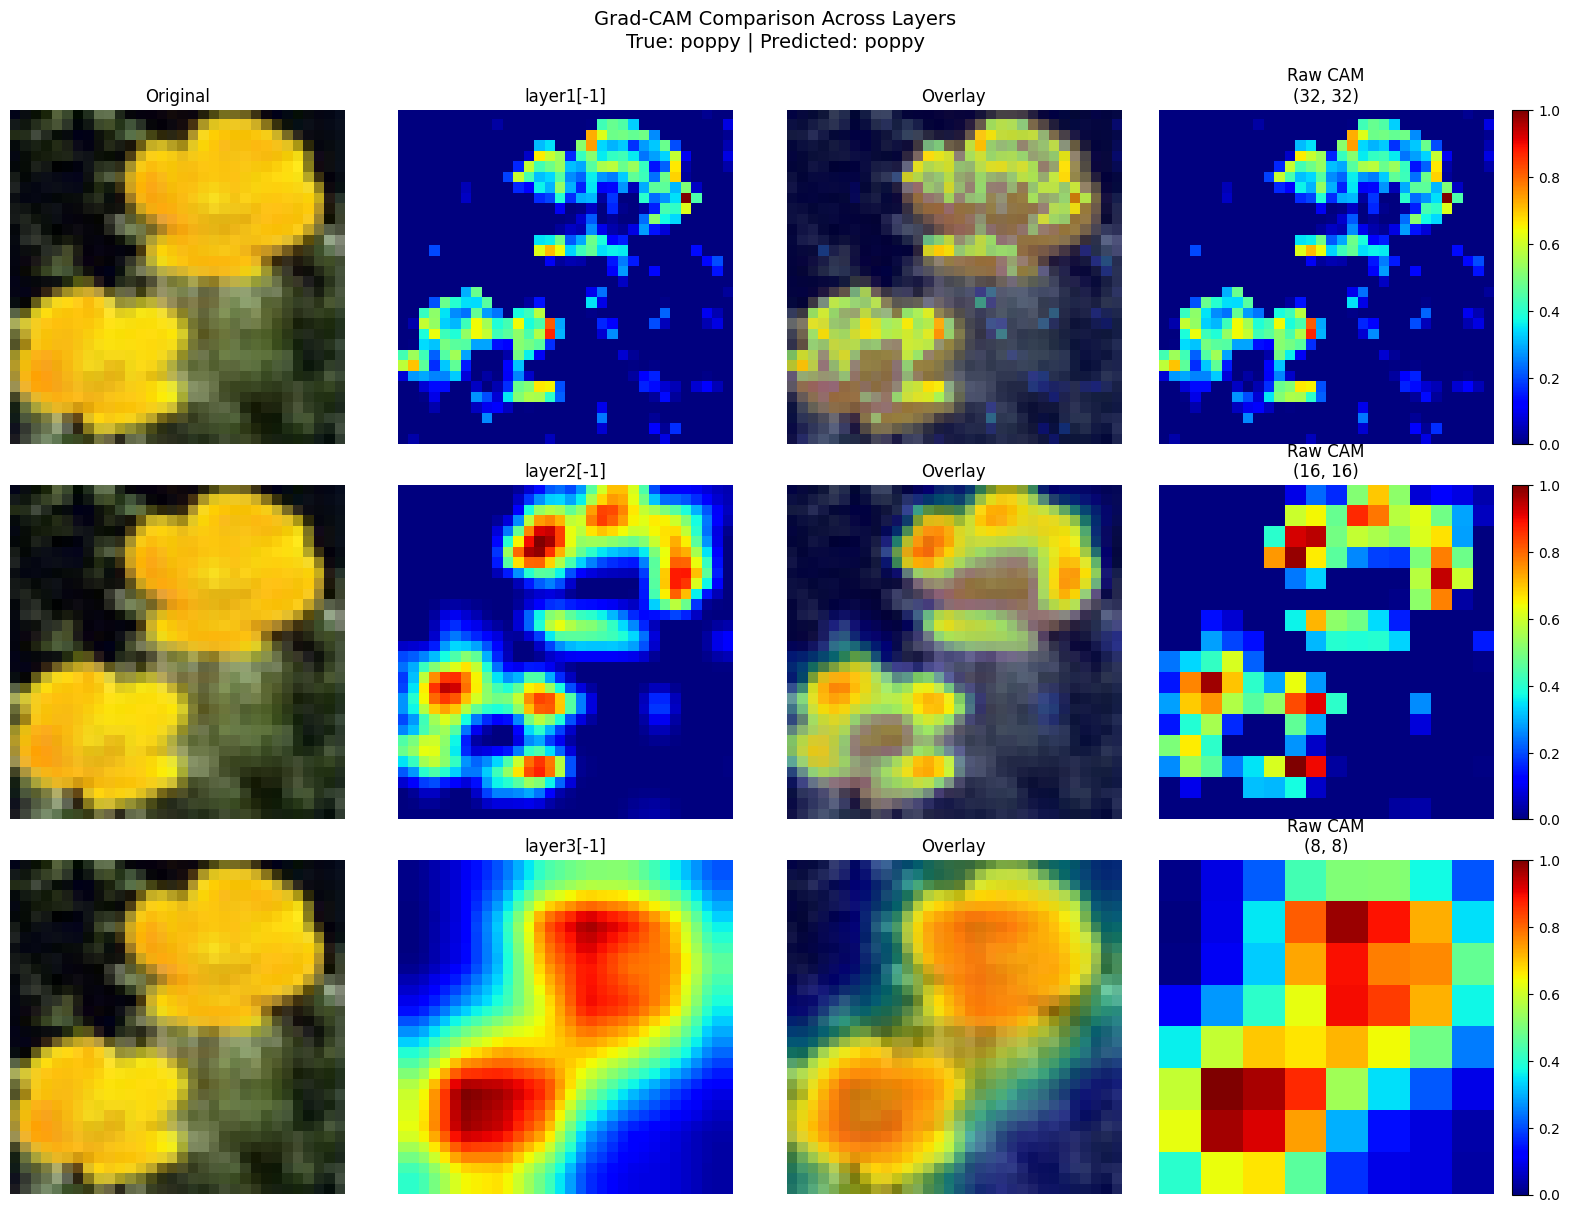

In [13]:
# Get a random test image
image_tensor, original_image, true_label, idx = get_random_image_from_dataset(test_dataset)
image_tensor = image_tensor.to(device)

# Compare different layers
layers_to_visualize = [
    ('layer1[-1]', model.layer1[-1]),
    ('layer2[-1]', model.layer2[-1]),
    ('layer3[-1]', model.layer3[-1])
]

fig, axes = plt.subplots(len(layers_to_visualize), 4, figsize=(16, 4*len(layers_to_visualize)))

for i, (layer_name, layer) in enumerate(layers_to_visualize):
    # Initialize Grad-CAM for this layer
    gradcam = GradCAM(model, target_layer=layer)
    
    # Generate CAM
    cam, pred_class = gradcam.generate_cam(image_tensor)
    
    # Resize CAM
    import cv2
    from matplotlib import cm
    cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    heatmap = cm.jet(cam_resized)[:, :, :3]
    superimposed = heatmap * 0.4 + original_image * 0.6
    superimposed = np.clip(superimposed, 0, 1)
    
    # Plot
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original' if i == 0 else '')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(cam_resized, cmap='jet')
    axes[i, 1].set_title(f'{layer_name}')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(superimposed)
    axes[i, 2].set_title('Overlay')
    axes[i, 2].axis('off')
    
    # Show raw heatmap values
    im = axes[i, 3].imshow(cam, cmap='jet')
    axes[i, 3].set_title(f'Raw CAM\n{cam.shape}')
    axes[i, 3].axis('off')
    plt.colorbar(im, ax=axes[i, 3], fraction=0.046)

plt.suptitle(f'Grad-CAM Comparison Across Layers\nTrue: {cifar100_classes[true_label]} | Predicted: {cifar100_classes[pred_class]}', 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

### Example 3: Visualize Specific Image and Layer

You can customize which image and which layer/block to visualize.

Example 1: Random image, layer3, last block
Image Index: 5191
True Label: cockroach
Target Layer: layer3[-1]


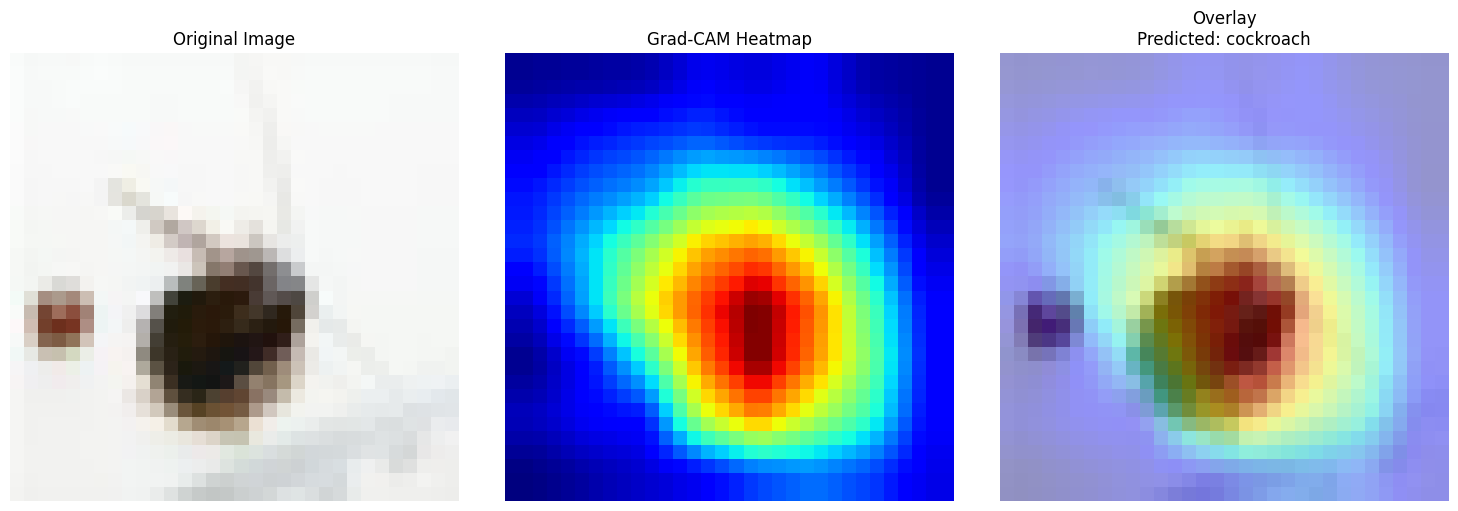



Example 2: Image #42, layer2, middle block
Image Index: 42
True Label: mountain
Target Layer: layer2[4]


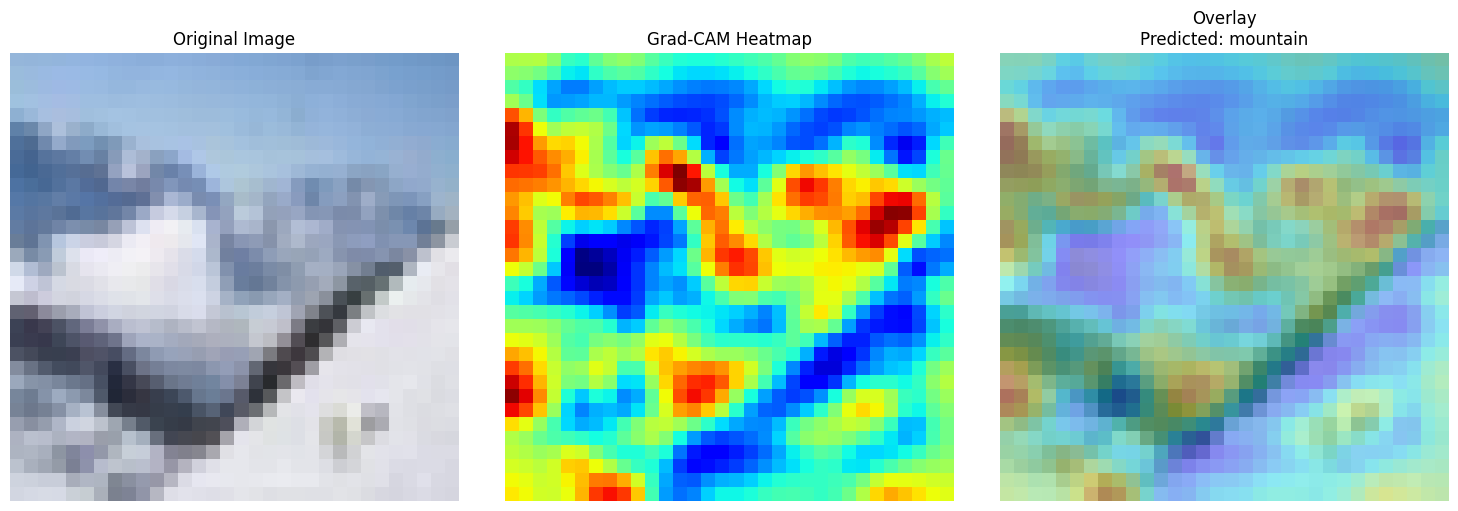

42

In [14]:
# Custom function to visualize Grad-CAM for any image and layer
def visualize_gradcam(image_idx=None, layer_name='layer3', block_idx=-1):
    """
    Visualize Grad-CAM for a specific image and layer
    
    Args:
        image_idx: Index of test image (None for random)
        layer_name: 'layer1', 'layer2', or 'layer3'
        block_idx: Block index within the layer (e.g., 0, -1, 5)
    """
    # Get image
    image_tensor, original_image, true_label, idx = get_random_image_from_dataset(
        test_dataset, idx=image_idx
    )
    image_tensor = image_tensor.to(device)
    
    # Get the target layer
    if layer_name == 'layer1':
        target_layer = model.layer1[block_idx]
    elif layer_name == 'layer2':
        target_layer = model.layer2[block_idx]
    elif layer_name == 'layer3':
        target_layer = model.layer3[block_idx]
    else:
        raise ValueError(f"Invalid layer_name: {layer_name}")
    
    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer=target_layer)
    
    # Visualize
    print(f'Image Index: {idx}')
    print(f'True Label: {cifar100_classes[true_label]}')
    print(f'Target Layer: {layer_name}[{block_idx}]')
    
    fig = gradcam.visualize(image_tensor, original_image, class_names=cifar100_classes)
    plt.show()
    
    return idx


# Example usage:
# Visualize a random image using the last block of layer3
print("Example 1: Random image, layer3, last block")
visualize_gradcam(image_idx=None, layer_name='layer3', block_idx=-1)

print("\n" + "="*80 + "\n")

# Visualize a specific image (e.g., index 42) using middle block of layer2
print("Example 2: Image #42, layer2, middle block")
visualize_gradcam(image_idx=42, layer_name='layer2', block_idx=4)

### Example 4: Batch Visualization

Visualize multiple random images at once.

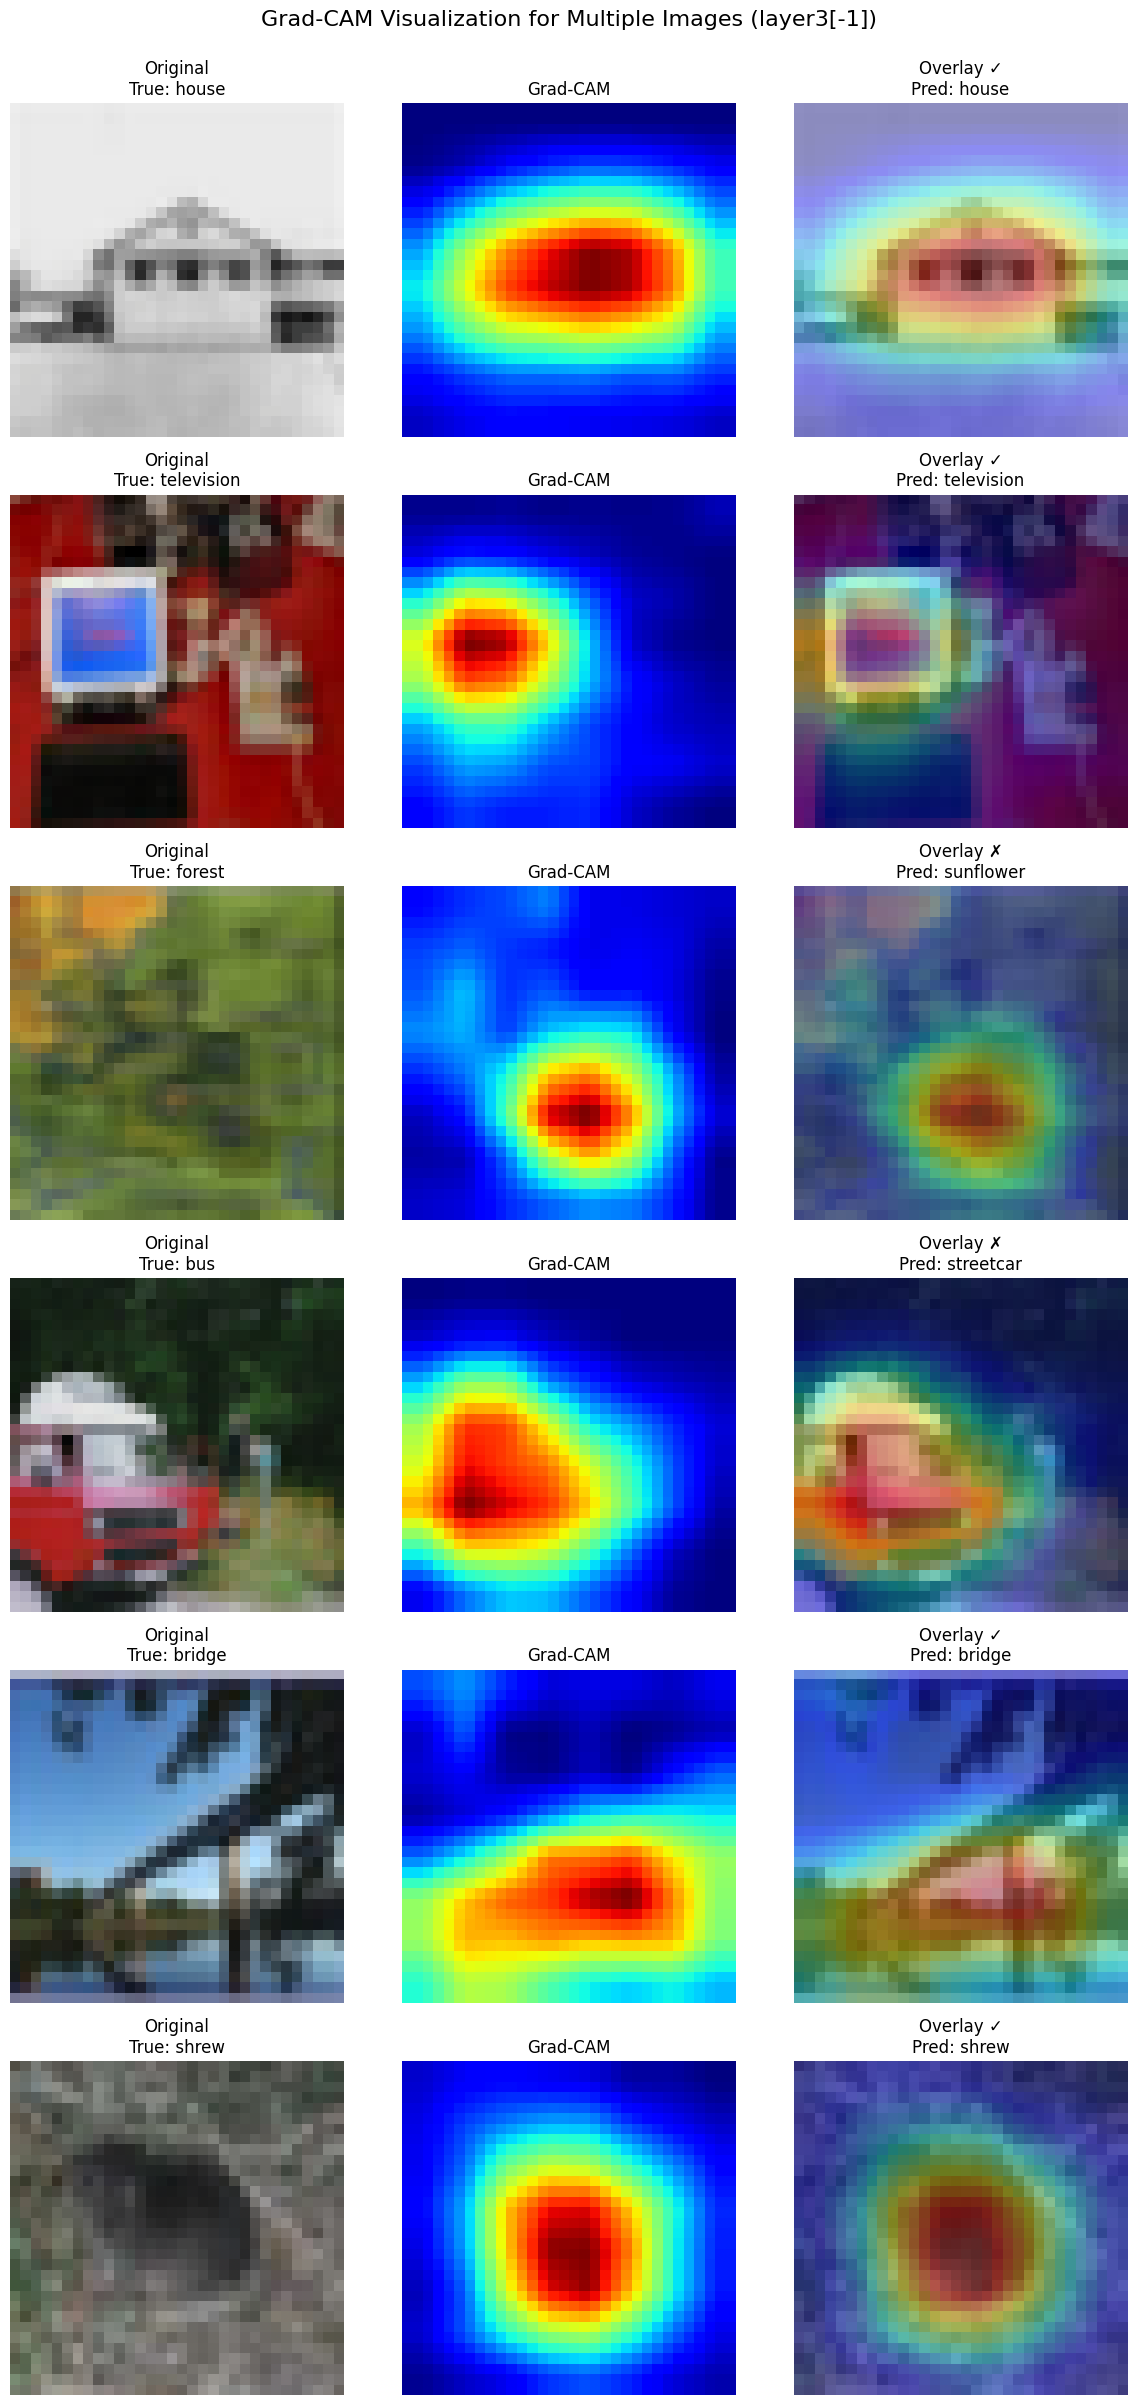

In [15]:
# Visualize multiple random images
num_images = 6
fig, axes = plt.subplots(num_images, 3, figsize=(12, 4*num_images))

# Use the last layer for all visualizations
gradcam = GradCAM(model, target_layer=model.layer3[-1])

for i in range(num_images):
    # Get random image
    image_tensor, original_image, true_label, idx = get_random_image_from_dataset(test_dataset)
    image_tensor = image_tensor.to(device)
    
    # Generate CAM
    cam, pred_class = gradcam.generate_cam(image_tensor)
    
    # Resize and overlay
    import cv2
    from matplotlib import cm
    cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    heatmap = cm.jet(cam_resized)[:, :, :3]
    superimposed = heatmap * 0.4 + original_image * 0.6
    superimposed = np.clip(superimposed, 0, 1)
    
    # Plot
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title(f'Original\nTrue: {cifar100_classes[true_label]}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(cam_resized, cmap='jet')
    axes[i, 1].set_title('Grad-CAM')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(superimposed)
    correct = '✓' if pred_class == true_label else '✗'
    axes[i, 2].set_title(f'Overlay {correct}\nPred: {cifar100_classes[pred_class]}')
    axes[i, 2].axis('off')

plt.suptitle('Grad-CAM Visualization for Multiple Images (layer3[-1])', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()